In [1]:
import pandas as pd
import numpy as np

# NLP
import spacy
import gensim


# Classification models
import sklearn.cluster
import sklearn.tree
import sklearn.naive_bayes

# Word Embedding
from sentence_transformers import SentenceTransformer

# Extras
from sklearn.model_selection import KFold
import random
from scipy.spatial import distance
import time
from collections import Counter 


In [2]:
# PATHS
# This the path to run the main example, for your data change the path to your data
 
pathData = r'../../data/CPN27.csv'         # Path of the data to test the model
pathEmbedding = r'../../data/SBW-vectors-300-min5.bin.gz'  # For example in Spanish

In [3]:
# VARIABLES
numberCluster = 500 # Number of clusters for the k-means model
numberCodes = 3 # Number of code you want as suggestion.
language = "spanish" #you can change to "english"
vertor_lenght = 768

## [Language Setting](#language-setting)

In [4]:
# Data import
# Relative Path of the dataset, change for your dataset
data = pd.read_csv(pathData, delimiter=",")


In [5]:
# The most important is the order of the 3 rows (Concept, Feature, and Code), the name itself is not important.
# Code is important for the training of the model.
data.head(5)

,Palabra (concepto),Descripción,Codificación
0,Compasión,sentimiento,sentimiento
1,Compasión,por lo que se le perdona la vida a alguien en ...,perdón
2,plan,necesario para cumplir objetivos,objetivos
3,plan,organizar recursos o personas,organización
4,plan,estrategia,estrategia


Installation of the Spanish pipeline. Change depending on the language you are using it.

More info in the page of spacy.

In [6]:
# Download each one depending on your language preference

# if language=="spanish":
#     !python -m spacy download es_core_news_sm    
# else:
#     !python -m spacy download en_core_news_sm


In [7]:
# Configuration of spacy
if language=="spanish":
    nlp = spacy.load('es_core_news_sm')
else:
    nlp = spacy.load('en_core_news_sm')



## [Important functions](##important-functions)

In [8]:
def clean_text(text):
    """
    Recive a string and return the string in tokens without punctuations
    and in lowercase
    """
    # for each token in the sentence add to the list if is not a punctuation
    return [t for t in nlp(text.lower()) if not t.is_punct]


def normalize(tokens):
    """
    Recive al list of string and return in one string without stop words
    """
    # for each token if is not a stop word add the word to the list
    words = [t.orth_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(words))

# Just in case you want to use it replace for normalize
def lematize(tokens):
    """
    Recive al list of string and return in one string without stop words 
    and Lematized
    """
    # for each token if is not a stop word add the lemma of the word in the list
    lemmas = [t.lemma_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(lemmas))


def to_vector(texto, model):
    """ 
    Receives a sentence string along with a word embedding model and 
    returns the vector representation of the sentence
    """
    return model.encode(texto)

## [Data Cleaning](##data-cleaning)

In [9]:
# start = time.time()
# # Normalize of the feature
# for i in range(len(data)):
#     data['Respuesta'][i] = normalize(clean_text(data['Respuesta'][i])) # Change for the name of your dataset
# end = time.time()
# print("Exceution time:", end-start)

In [10]:
# Timer
start = time.time()

# Load of the LaBSE model
model = SentenceTransformer('sentence-transformers/LaBSE')

# Creation of the matrix to make the clustering process
descriptions_matrix = np.zeros( # creatign an empty matrix
    (
        len(data),          # the number of data points
        vertor_lenght       # the number of components of the word embedding
    )
)

# Matrix filling 
# Change to the name of the descriptions of your dataset.
for i,description in enumerate(data.iloc[:,1]):
    vector = to_vector(description,model)
    descriptions_matrix[i,] = vector

# Concatenate the matrix with the data of each observation
data_matrix = np.concatenate([descriptions_matrix,data], axis=1)


# Remove of the 'Nan' data
data_matrix = data_matrix[~pd.isnull(data_matrix[:,:vertor_lenght]).any(axis=1)]


end = time.time()
print("Exceution time:", end-start)

Exceution time: 198.46173334121704


## [Model](#model)

We create a class for the text classification, were initially you have to set the number of clusters you want to use for your model.

In [11]:
class AC_PLT:

    def __init__(self, n_clusters = 500, random_state=0, vec_len=300):
        """
        n_clusters: number of cluster in the k-Means model
        """
        
        self.vec_len=vec_len
        self.n_clusters = n_clusters # number of clusters
        self.KMeans_dict = {} # dictionary of all the humans codifications for each Cluster
        self.KMeans_categories = {} # dictionary for the most frecuent value in the centroid
        self.km = sklearn.cluster.KMeans(           # creates de k-means object
            n_clusters=self.n_clusters, 
            random_state=random_state,
            n_init='auto'
        ) 
        
        
    def most_frequent(self, List): 
        """
        Recives a list of words, and return the word most frequente of
        the list
        """
        # counter of occurence of a code in a list
        occurence_count = Counter(List) 
        
        # Return the first code with more occurence
        return occurence_count.most_common(1)[0][0] 


    def fit(self, train):
        """
        Recives the train dataset and the number of clusters to train 
        the k-means model
        """
        # Train the k-means algorithm
        self.km.fit(train[:,:self.vec_len])

        # Dataframe of train dataset
        df = pd.DataFrame(
            np.concatenate([
                np.reshape(train[:,self.vec_len+2], (-1, 1)),          # Human codification
                np.reshape(self.km.labels_, (-1, 1)),       # Number of the KMean centroid
                np.reshape(train[:,self.vec_len], (-1, 1))           # Concept of the codification
                ], axis=1), 
            columns=['Human', 'KMeans', 'Concept'])

        # create a dictionary of all the humans codifications for each Cluster
        self.KMeans_dict = df.groupby(by='KMeans')['Human'].apply(list).to_dict()

        # Fill a dictionary with the most frecuent value in the centroid
        for key, val in self.KMeans_dict.items():
            self.KMeans_categories[key] = self.most_frequent(val)
        
        # Generates the prediction for the train dataset
        df['KM_Prediction'] = df['KMeans'].map(self.KMeans_categories)


    def get_distances(self, test):
        """
        recives the test data to calculate the distances of each frase, return 
        a matrix with the distances sorted
        """
        
        # Distance matrix of each test point to each cluster center
        distance_matrix = distance.cdist(test[:,:self.vec_len].astype(float), self.km.cluster_centers_, 'euclidean')
        
        # Sorting distances
        self.topk=np.argsort(distance_matrix,axis=1)
        
    
    def set_labels(self):
        """
        Create a new matrix from the clusters sorted and change the value
        from numeric to the string according the codification
        """
        # Change of the numeric value to the codification 
        self.topKS=pd.DataFrame(self.topk)

        # create a temporal array of the kmeans categories
        tempData = np.array([value for (_, value) in sorted(self.KMeans_categories.items())])
        
        # print(tempData)

        # for each cluster center
        for j in range(self.topKS.shape[1]):
            # set the codification of the numeric value in the topk list
            self.topKS.iloc[:,j]=tempData[self.topk[:,j]]


    def get_accuracies(self, test):
        """
        Recives the test matrix and return the accuracies of the 
        diferents predictions
        """
        #Creating the accuracy table to check each data point
        testLabel=np.zeros(self.topKS.shape)
        indexes_method0=pd.DataFrame(np.zeros((self.topKS.shape[0],2)), columns=['index', 'value']) 

        #For each data point
        for i in range(testLabel.shape[0]):
            #Checking if some of the cluster is able to classify it right
            boolClass=self.topKS.iloc[i,:]==test[i,vertor_lenght+2]
            if sum(boolClass)>0:
                getIndex=boolClass.idxmax()
                indexes_method0.iloc[i,0] = getIndex
                indexes_method0.iloc[i,1] = self.topKS.iloc[i,getIndex]
                #Setting the rest of the data point as 1
                testLabel[i,getIndex:]=1
            else:
                indexes_method0.iloc[i,0] = np.nan
                indexes_method0.iloc[i,1] = np.nan
        accuracies=testLabel.sum(axis=0)/testLabel.shape[0]

        return accuracies

    
    def transform(self, test):
        """
        Recives two numpy bi-dimentionals arrays and returns the accuracy of the model
        """
        self.get_distances(test)
        self.set_labels()
        return self.get_accuracies(test)
    
    def suggestions(self, test, n_codes):
        self.get_distances(test)
        self.set_labels()
        return pd.DataFrame(
            np.concatenate([
                np.reshape(test[:, self.vec_len], (-1, 1)), 
                np.reshape(test[:, self.vec_len+1], (-1, 1)), 
                self.topKS.iloc[:, :n_codes]],
                axis=1
                ), 
            columns=['Concept', 'Description']+['top-{} suggestion'.format(i+1) for i in range(numberCodes)]
            )
        
    

In [12]:
# K = 500
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k500_acc_top_test = np.zeros((5, 5))
k500_acc_top_train = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix):
    train = data_matrix[train_index, :]
    test = data_matrix[test_index, :]
    
    proc = AC_PLT(vec_len=vertor_lenght)
    
    print("iteration:", i+1)
    # Train process
    start = time.time()
    proc.fit(train)
    end = time.time()
    print("Train process time:", end-start)
    
    # Clasification process
    start = time.time()
    acc_train = proc.transform(train)
    acc_test = proc.transform(test)
    end = time.time()
    print("Clasification process time:", end-start)


    for j in range(len(tops)):
        k500_acc_top_train[i,j] = acc_train[tops[j]]
        k500_acc_top_test[i,j] = acc_test[tops[j]]

    i+=1

iteration: 1
Train process time: 2.524069309234619
Clasification process time: 6.459058046340942
iteration: 2
Train process time: 1.7058520317077637
Clasification process time: 6.104965686798096
iteration: 3
Train process time: 1.6634962558746338
Clasification process time: 6.212266445159912
iteration: 4
Train process time: 1.735102653503418
Clasification process time: 6.123628616333008
iteration: 5
Train process time: 1.6518990993499756
Clasification process time: 6.128185749053955


In [15]:
print(k500_acc_top_train.mean(axis=0))
print(k500_acc_top_train.std(axis=0))

[0.42319761 0.48086254 0.50637853 0.53670416 0.59558457]
[0.00460748 0.00833146 0.01015009 0.01110706 0.00886692]


In [18]:
print(k500_acc_top_test.mean(axis=0))
print(k500_acc_top_test.std(axis=0))

[0.27966746 0.3614835  0.3981402  0.43317438 0.51154667]
[0.01199198 0.00863704 0.015237   0.02014079 0.03111069]


In [43]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

rango = range(100,1500+1,100)

k_acc_top_train = np.zeros((len(rango), 10))
k_acc_top_test = np.zeros((len(rango), 10))

tops=[0,2,4,9,49]

j = 0
for k in rango:
    x=0

    train_temp = np.zeros((5,5))
    test_temp = np.zeros((5,5))


    for train_index, test_index in kfold.split(data_matrix):
        train = data_matrix[train_index, :]
        test = data_matrix[test_index, :]
        
        proc = AC_PLT(n_clusters=k, vec_len=vertor_lenght)
        

        start = time.time()
        proc.fit(train)


        acc_train = proc.transform(train)
        acc_test = proc.transform(test)
        
        # print(acc_train)

        train_temp[x] = acc_train[tops]
        test_temp[x] = acc_test[tops]
        x+=1

    for i in range(5):
        # print(train_temp.std(axis=0))
        k_acc_top_train[j, i*2] = train_temp.mean(axis=0)[i]
        k_acc_top_train[j, i*2+1] = train_temp.std(axis=0)[i]

        k_acc_top_test[j, i*2] = test_temp.mean(axis=0)[i]
        k_acc_top_test[j, i*2+1] = test_temp.std(axis=0)[i]

    j+=1
    print("K =", k)

K = 100
K = 200
K = 300
K = 400
K = 500
K = 600
K = 700
K = 800
K = 900
K = 1000
K = 1100
K = 1200
K = 1300
K = 1400
K = 1500


In [44]:
# Save the results of the search of the hyperparameter k
np.savetxt("k_acc_top_test_labse_CPN120.csv",k_acc_top_test,delimiter=',')
np.savetxt("k_acc_top_train_labse_CPN120.csv",k_acc_top_train,delimiter=',')

In [2]:
# Reload of results of the search of the hyperparameter k
k_acc_top_test=pd.read_csv(r"k_acc_top_test_labse_CPN120.csv", header=None).to_numpy()
k_acc_top_train=pd.read_csv(r"k_acc_top_train_labse_CPN120.csv", header=None).to_numpy()

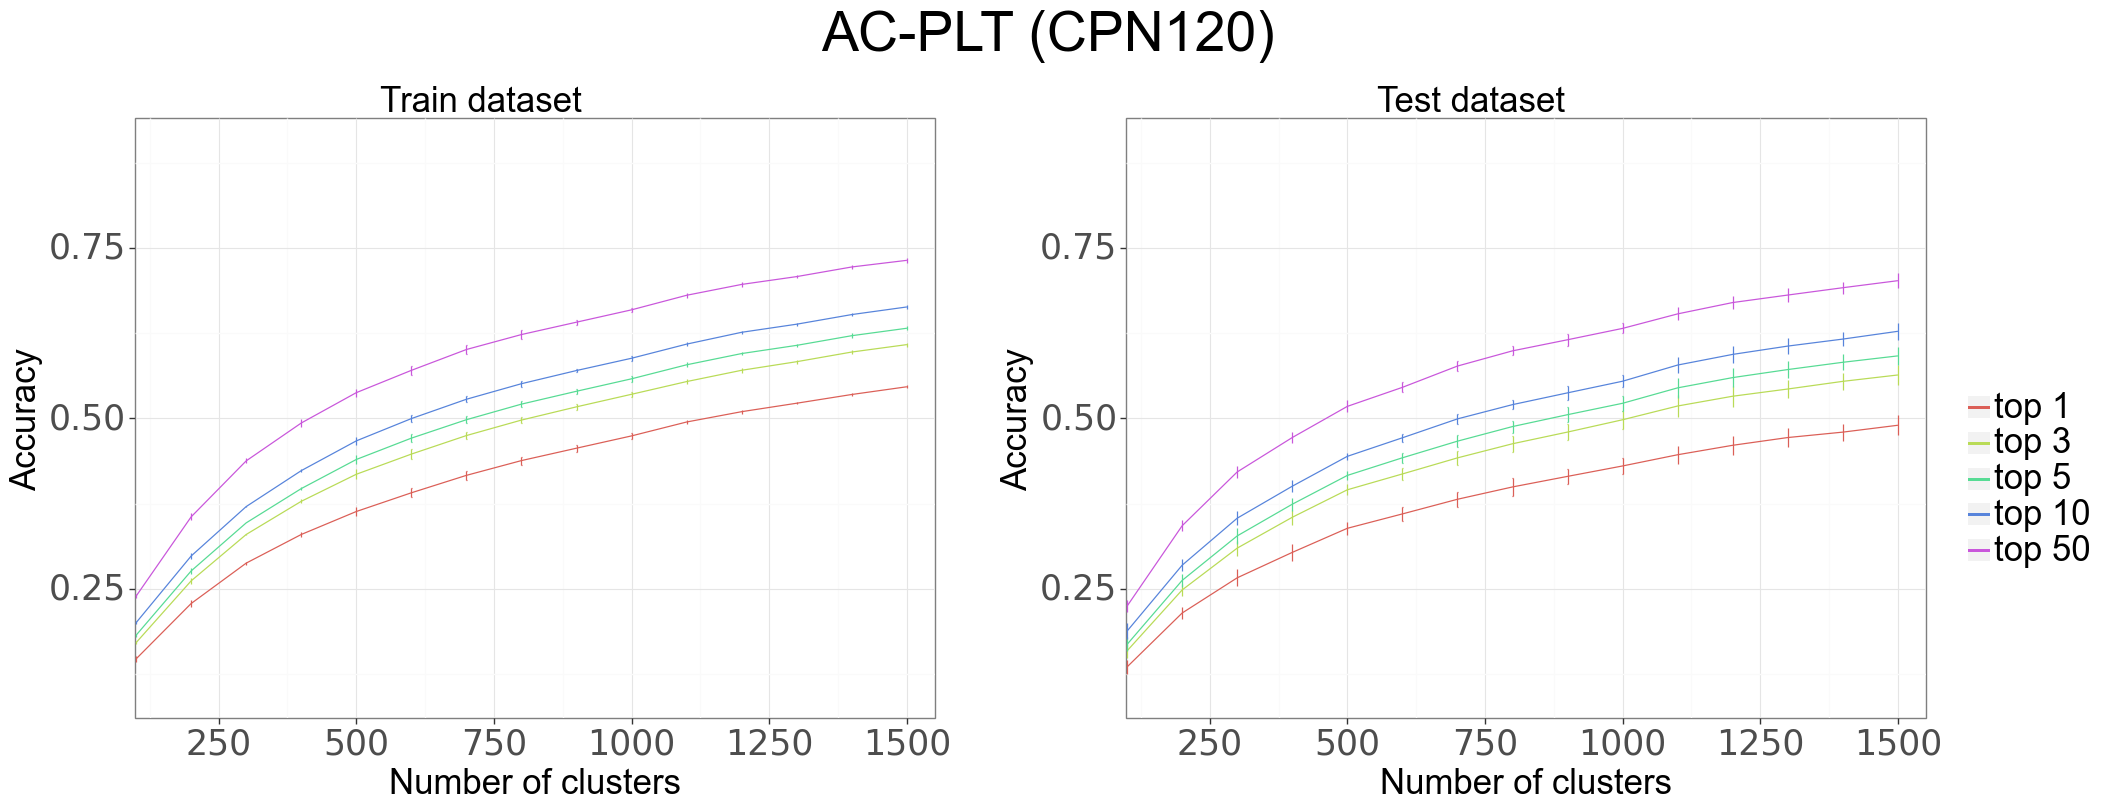

In [4]:
from numpy import size
from plotnine import *
import patchworklib as pw

rango = range(100,1500+1,100)

p1 = (
    ggplot()+
    aes(x=rango, color='')+
    geom_line(aes(y=k_acc_top_test[:,0], color="'top 1'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,0]-k_acc_top_test[:,1], ymax = k_acc_top_test[:,0]+k_acc_top_test[:,1], color="'top 1'"))+
    geom_line(aes(y=k_acc_top_test[:,2], color="'top 3'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,2]-k_acc_top_test[:,3], ymax = k_acc_top_test[:,2]+k_acc_top_test[:,3], color="'top 3'"))+
    geom_line(aes(y=k_acc_top_test[:,4], color="'top 5'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,4]-k_acc_top_test[:,5], ymax = k_acc_top_test[:,4]+k_acc_top_test[:,5], color="'top 5'"))+
    geom_line(aes(y=k_acc_top_test[:,6], color="'top 10'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,6]-k_acc_top_test[:,7], ymax = k_acc_top_test[:,6]+k_acc_top_test[:,7], color="'top 10'"))+
    geom_line(aes(y=k_acc_top_test[:,8], color="'top 50'"))+
    geom_errorbar(aes(ymin = k_acc_top_test[:,8]-k_acc_top_test[:,9], ymax = k_acc_top_test[:,8]+k_acc_top_test[:,9], color="'top 50'"))+
    xlab("Number of clusters")+
    ylab("Accuracy")+
    ggtitle("Test dataset")+
    theme_bw()+
    theme(text=element_text(size=25))+
    scale_y_continuous(limits = (0.1, 0.9))+
    scale_x_continuous(limits=(99, 1550), breaks=range(0, 1501, 250), expand=(0,1))
)

p2 = (
    ggplot()+
    aes(x=rango, color='')+
    geom_line(aes(y=k_acc_top_train[:,0], color="'top 1'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,0]-k_acc_top_train[:,1], ymax = k_acc_top_train[:,0]+k_acc_top_train[:,1], color="'top 1'"))+
    geom_line(aes(y=k_acc_top_train[:,2], color="'top 3'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,2]-k_acc_top_train[:,3], ymax = k_acc_top_train[:,2]+k_acc_top_train[:,3], color="'top 3'"))+
    geom_line(aes(y=k_acc_top_train[:,4], color="'top 5'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,4]-k_acc_top_train[:,5], ymax = k_acc_top_train[:,4]+k_acc_top_train[:,5], color="'top 5'"))+
    geom_line(aes(y=k_acc_top_train[:,6], color="'top 10'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,6]-k_acc_top_train[:,7], ymax = k_acc_top_train[:,6]+k_acc_top_train[:,7], color="'top 10'"))+
    geom_line(aes(y=k_acc_top_train[:,8], color="'top 50'"))+
    geom_errorbar(aes(ymin = k_acc_top_train[:,8]-k_acc_top_train[:,9], ymax = k_acc_top_train[:,8]+k_acc_top_train[:,9], color="'top 50'"))+
    xlab("Number of clusters")+
    ylab("Accuracy")+
    ggtitle("Train dataset")+
    theme_bw()+
    theme(legend_position = "none", text=element_text(size=25))+
    scale_y_continuous(limits = (0.1, 0.9))+
    scale_x_continuous(limits=(99, 1550), breaks=range(0, 1501, 250), expand=(0,1))
)

# gray = 

p1 = pw.load_ggplot(p1, figsize=(8,6))
p2 = pw.load_ggplot(p2, figsize=(8,6))

p12 = (p2|p1)
p12.set_text(text="AC-PLT (CPN120)",x=0.42,y=1.1, size=40)
p12.savefig("labse_AC-PLT_cpn120.png")